
# Audio Data Augmentation

**Author**: [Moto Hira](moto@meta.com)_

``torchaudio`` provides a variety of ways to augment audio data.

In this tutorial, we look into a way to apply effects, filters,
RIR (room impulse response) and codecs.

At the end, we synthesize noisy speech over phone from clean speech.


In [1]:
import torch
import torchaudio
import torchaudio.io
import torchaudio.functional as F

print(torch.__version__)
print(torchaudio.__version__)

import matplotlib.pyplot as plt

2.1.0+cu121
2.1.0+cu121


## Preparation

First, we import the modules and download the audio assets we use in this tutorial.




In [2]:
from IPython.display import Audio

from torchaudio.utils import download_asset

SAMPLE_WAV = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.wav")
SAMPLE_RIR = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo-8000hz.wav")
SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")
SAMPLE_NOISE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo-8000hz.wav")

## Applying effects and filtering

:py:class:`torchaudio.io.AudioEffector` allows for directly applying
filters and codecs to Tensor objects, in a similar way as ``ffmpeg``
command

`AudioEffector Usages <./effector_tutorial.html>` explains how to use
this class, so for the detail, please refer to the tutorial.




In [3]:
# Load the data
waveform1, sample_rate = torchaudio.load(SAMPLE_WAV, channels_first=False)

# Define effects
effect = ",".join(
    [
        "lowpass=frequency=300:poles=1",  # apply single-pole lowpass filter
        "atempo=0.8",  # reduce the speed
        "aecho=in_gain=0.8:out_gain=0.9:delays=200:decays=0.3|delays=400:decays=0.3"
        # Applying echo gives some dramatic feeling
    ],
)


# Apply effects
def apply_effect(waveform, sample_rate, effect):
    effector = torchaudio.io.AudioEffector(effect=effect)
    return effector.apply(waveform, sample_rate)


waveform2 = apply_effect(waveform1, sample_rate, effect)

print(waveform1.shape, sample_rate)
print(waveform2.shape, sample_rate)

torch.Size([109368, 2]) 44100
torch.Size([144642, 2]) 44100


Note that the number of frames and number of channels are different from
those of the original after the effects are applied. Let’s listen to the
audio.




In [4]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)

In [5]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)

### Original




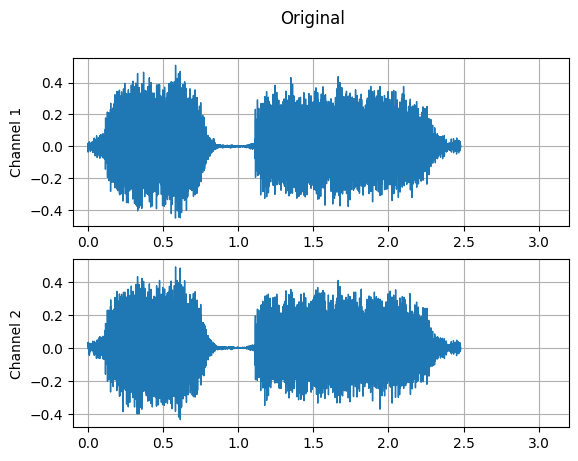

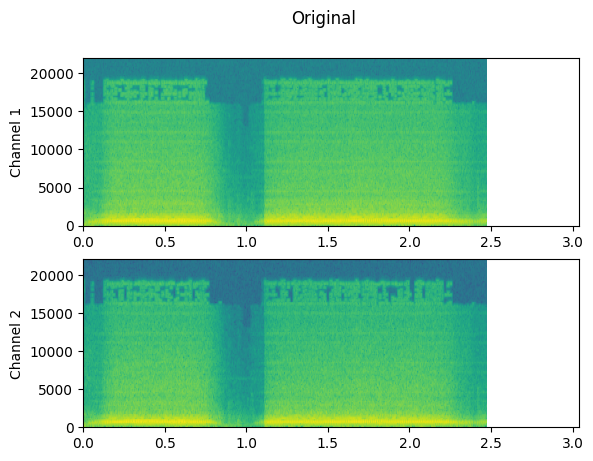

In [6]:
plot_waveform(waveform1.T, sample_rate, title="Original", xlim=(-0.1, 3.2))
plot_specgram(waveform1.T, sample_rate, title="Original", xlim=(0, 3.04))
Audio(waveform1.T, rate=sample_rate)

### Effects applied




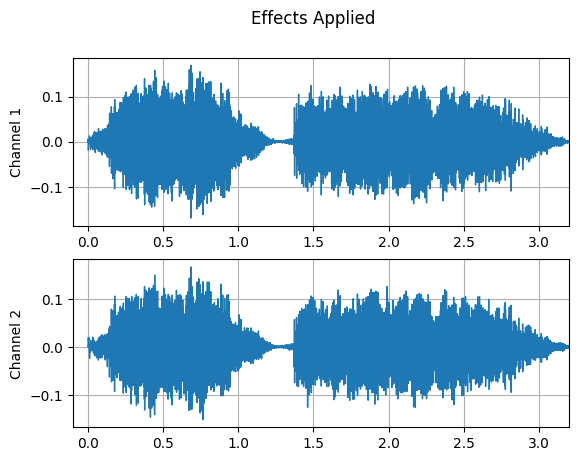

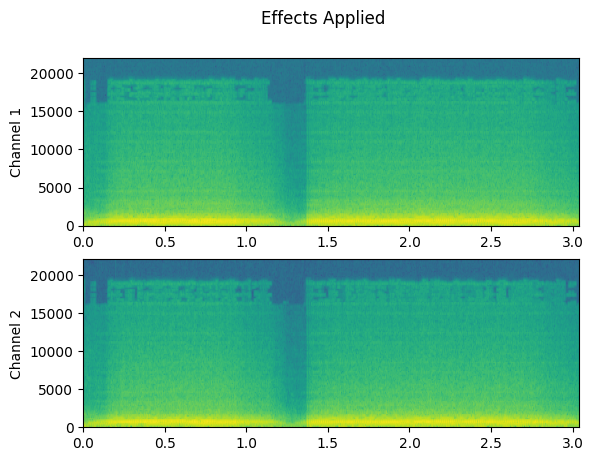

In [7]:
plot_waveform(waveform2.T, sample_rate, title="Effects Applied", xlim=(-0.1, 3.2))
plot_specgram(waveform2.T, sample_rate, title="Effects Applied", xlim=(0, 3.04))
Audio(waveform2.T, rate=sample_rate)

## Simulating room reverberation

[Convolution
reverb](https://en.wikipedia.org/wiki/Convolution_reverb)_ is a
technique that's used to make clean audio sound as though it has been
produced in a different environment.

Using Room Impulse Response (RIR), for instance, we can make clean speech
sound as though it has been uttered in a conference room.

For this process, we need RIR data. The following data are from the VOiCES
dataset, but you can record your own — just turn on your microphone
and clap your hands.




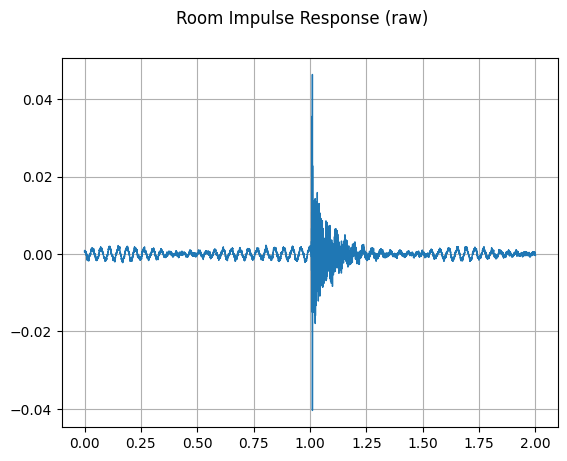

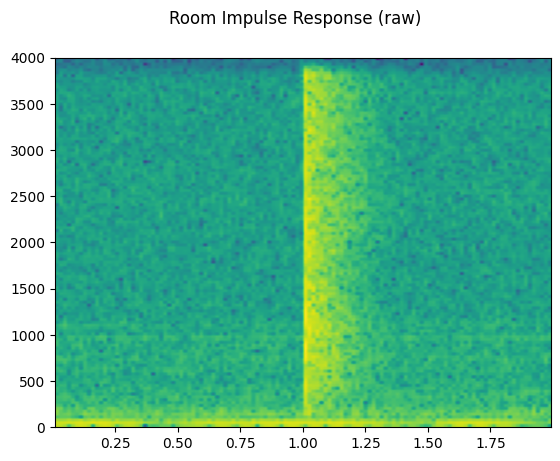

In [22]:
rir_raw, sample_rate = torchaudio.load(SAMPLE_RIR)
plot_waveform(rir_raw, sample_rate, title="Room Impulse Response (raw)")
plot_specgram(rir_raw, sample_rate, title="Room Impulse Response (raw)")
Audio(rir_raw, rate=sample_rate)

First, we need to clean up the RIR. We extract the main impulse and normalize
it by its power.




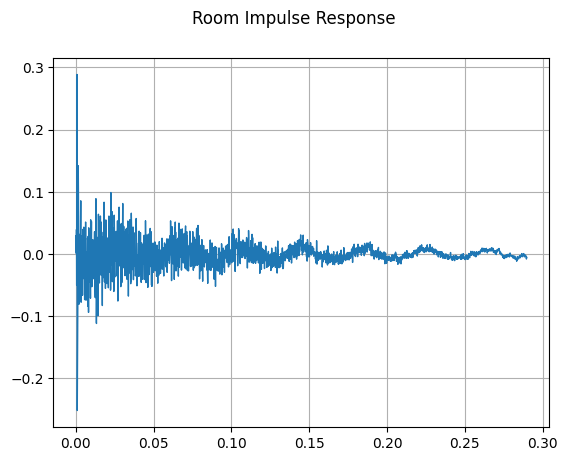

In [23]:
rir = rir_raw[:, int(sample_rate * 1.01) : int(sample_rate * 1.3)]
rir = rir / torch.linalg.vector_norm(rir, ord=2)

plot_waveform(rir, sample_rate, title="Room Impulse Response")

Then, using :py:func:`torchaudio.functional.fftconvolve`,
we convolve the speech signal with the RIR.




In [25]:
speech, _ = torchaudio.load(SAMPLE_SPEECH)
augmented = F.fftconvolve(speech, rir)

AttributeError: module 'torchaudio.functional' has no attribute 'fftconvolve'

### Original




In [ ]:
plot_waveform(speech, sample_rate, title="Original")
plot_specgram(speech, sample_rate, title="Original")
Audio(speech, rate=sample_rate)

### RIR applied




In [ ]:
plot_waveform(augmented, sample_rate, title="RIR Applied")
plot_specgram(augmented, sample_rate, title="RIR Applied")
Audio(augmented, rate=sample_rate)

## Adding background noise

To introduce background noise to audio data, we can add a noise Tensor to
the Tensor representing the audio data according to some desired
signal-to-noise ratio (SNR)
[[wikipedia](https://en.wikipedia.org/wiki/Signal-to-noise_ratio)_],
which determines the intensity of the audio data relative to that of the noise
in the output.

$$ \\mathrm{SNR} = \\frac{P_{signal}}{P_{noise}} $$

$$ \\mathrm{SNR_{dB}} = 10 \\log _{{10}} \\mathrm {SNR} $$

To add noise to audio data per SNRs, we
use :py:func:`torchaudio.functional.add_noise`.



In [ ]:
speech, _ = torchaudio.load(SAMPLE_SPEECH)
noise, _ = torchaudio.load(SAMPLE_NOISE)
noise = noise[:, : speech.shape[1]]

snr_dbs = torch.tensor([20, 10, 3])
noisy_speeches = F.add_noise(speech, noise, snr_dbs)

### Background noise




In [ ]:
plot_waveform(noise, sample_rate, title="Background noise")
plot_specgram(noise, sample_rate, title="Background noise")
Audio(noise, rate=sample_rate)

### SNR 20 dB




In [ ]:
snr_db, noisy_speech = snr_dbs[0], noisy_speeches[0:1]
plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
plot_specgram(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
Audio(noisy_speech, rate=sample_rate)

### SNR 10 dB




In [ ]:
snr_db, noisy_speech = snr_dbs[1], noisy_speeches[1:2]
plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
plot_specgram(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
Audio(noisy_speech, rate=sample_rate)

### SNR 3 dB




In [ ]:
snr_db, noisy_speech = snr_dbs[2], noisy_speeches[2:3]
plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
plot_specgram(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
Audio(noisy_speech, rate=sample_rate)

## Applying codec to Tensor object

:py:class:`torchaudio.io.AudioEffector` can also apply codecs to
a Tensor object.




In [ ]:
waveform, sample_rate = torchaudio.load(SAMPLE_SPEECH, channels_first=False)


def apply_codec(waveform, sample_rate, format, encoder=None):
    encoder = torchaudio.io.AudioEffector(format=format, encoder=encoder)
    return encoder.apply(waveform, sample_rate)

### Original




In [ ]:
plot_waveform(waveform.T, sample_rate, title="Original")
plot_specgram(waveform.T, sample_rate, title="Original")
Audio(waveform.T, rate=sample_rate)

### 8 bit mu-law




In [ ]:
mulaw = apply_codec(waveform, sample_rate, "wav", encoder="pcm_mulaw")
plot_waveform(mulaw.T, sample_rate, title="8 bit mu-law")
plot_specgram(mulaw.T, sample_rate, title="8 bit mu-law")
Audio(mulaw.T, rate=sample_rate)

### G.722




In [ ]:
g722 = apply_codec(waveform, sample_rate, "g722")
plot_waveform(g722.T, sample_rate, title="G.722")
plot_specgram(g722.T, sample_rate, title="G.722")
Audio(g722.T, rate=sample_rate)

### Vorbis




In [ ]:
vorbis = apply_codec(waveform, sample_rate, "ogg", encoder="vorbis")
plot_waveform(vorbis.T, sample_rate, title="Vorbis")
plot_specgram(vorbis.T, sample_rate, title="Vorbis")
Audio(vorbis.T, rate=sample_rate)

## Simulating a phone recoding

Combining the previous techniques, we can simulate audio that sounds
like a person talking over a phone in a echoey room with people talking
in the background.




In [ ]:
sample_rate = 16000
original_speech, sample_rate = torchaudio.load(SAMPLE_SPEECH)

plot_specgram(original_speech, sample_rate, title="Original")

# Apply RIR
rir_applied = F.fftconvolve(speech, rir)

plot_specgram(rir_applied, sample_rate, title="RIR Applied")

# Add background noise
# Because the noise is recorded in the actual environment, we consider that
# the noise contains the acoustic feature of the environment. Therefore, we add
# the noise after RIR application.
noise, _ = torchaudio.load(SAMPLE_NOISE)
noise = noise[:, : rir_applied.shape[1]]

snr_db = torch.tensor([8])
bg_added = F.add_noise(rir_applied, noise, snr_db)

plot_specgram(bg_added, sample_rate, title="BG noise added")

# Apply filtering and change sample rate
effect = ",".join(
    [
        "lowpass=frequency=4000:poles=1",
        "compand=attacks=0.02:decays=0.05:points=-60/-60|-30/-10|-20/-8|-5/-8|-2/-8:gain=-8:volume=-7:delay=0.05",
    ]
)

filtered = apply_effect(bg_added.T, sample_rate, effect)
sample_rate2 = 8000

plot_specgram(filtered.T, sample_rate2, title="Filtered")

# Apply telephony codec
codec_applied = apply_codec(filtered, sample_rate2, "g722")
plot_specgram(codec_applied.T, sample_rate2, title="G.722 Codec Applied")

### Original speech




In [ ]:
Audio(original_speech, rate=sample_rate)

### RIR applied




In [ ]:
Audio(rir_applied, rate=sample_rate)

### Background noise added




In [ ]:
Audio(bg_added, rate=sample_rate)

### Filtered




In [ ]:
Audio(filtered.T, rate=sample_rate2)

### Codec applied




In [ ]:
Audio(codec_applied.T, rate=sample_rate2)